## 多GPU训练

In [50]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

torch.cuda.is_available(), torch.cuda.device_count()

(True, 2)

### 从0实现

In [51]:
# 定义LeNet
# 初始化模型参数
scale = 0.01
W1 = torch.randn((20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn((50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn((800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn((128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(X, params[0], params[1])
    h1_activation = F.relu(input=h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [52]:
# 此函数的作用为把参数移动到指定的device设备上
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1权重', new_params[1])
print('b1梯度', new_params[1].grad)

b1权重 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1梯度 None


#### 定义`all_reduce`函数
- 用于把所有的GPU上的数据都移动到GPU0上然后进行加和后广播

In [53]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

data = [torch.ones((1, 2)) * (i + 1) for i in range(2)]
print('allreduce之前\t', data)
allreduce(data)
print('allreduce之后\t', data)

allreduce之前	 [tensor([[1., 1.]]), tensor([[2., 2.]])]
allreduce之后	 [tensor([[3., 3.]]), tensor([[3., 3.]])]


#### 数据分发

In [54]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [55]:
def split_batch(X, y, devices):
    assert X.shape[0] == y.shape[0]
    return (
        nn.parallel.scatter(X, devices),
        nn.parallel.scatter(y, devices)
    )

#### train一个batch

In [56]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)

    # 在每个GPU上单独计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard) 
          for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]
    # 在每个GPU上单独计算梯度
    for l in ls:
        l.sum().backward()
    # 对梯度进行all_reduce运算
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))]
            )
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])

#### train函数

In [57]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
                         lambda x:lenet(x, device_params[0]), test_iter, devices[0]), ))
    print(f'测试精度：{animator.Y[0][-1]:.2f}', f'{timer.avg():.1f}秒/epoch',
          f'\n 在{str(devices)}')

测试精度：0.83 2.7秒/epoch 
 在[device(type='cuda', index=0)]


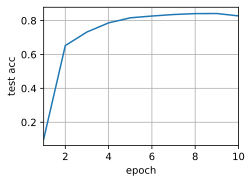

In [58]:
train(num_gpus=1, batch_size=128, lr=0.1)

测试精度：0.80 2.6秒/epoch 
 在[device(type='cuda', index=0), device(type='cuda', index=1)]


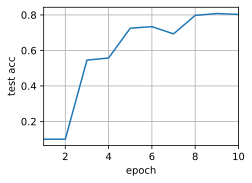

In [59]:
train(num_gpus=2, batch_size=128 * 2, lr=0.1 * 1.5)

### 简洁实现

In [60]:
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            # resnet在第一个residual block不缩小图像尺寸
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU()
    )
    net.add_module('resnet_block1', resnet_block(64, 64, 2, first_block=True))
    net.add_module('resnet_block2', resnet_block(64, 128, 2))
    net.add_module('resnet_block3', resnet_block(128, 256, 2))
    net.add_module('resnet_block4', resnet_block(256, 512, 2))
    net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module('fc', nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

In [61]:
net = resnet18(10)

devices = d2l.try_all_gpus()

In [ ]:
def train(net, num_gpus, batch_size, lr):
    # 获取数据dataloader
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter), ))
    print(f'测试精度{animator.Y[0][-1]:.2f}, {timer.avg():.2f}sec/epoch, 在{str(devices)}')



测试精度0.92, 20.974068331718446sec/epoch, 在[device(type='cuda', index=0)]


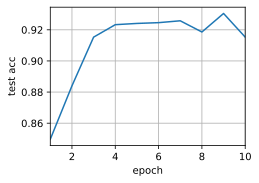

In [65]:
train(net, num_gpus=1, batch_size=128, lr=0.1)

测试精度0.75, 12.20890007019043sec/epoch, 在[device(type='cuda', index=0), device(type='cuda', index=1)]


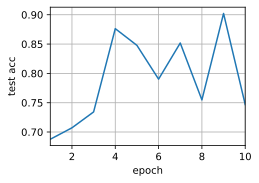

In [67]:
train(net, num_gpus=2, batch_size=256 * 2, lr=0.1 * 1.5)